You must have the data set in your Google drive account in order to work with it. It can be downloaded here:

https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2?usp=sharing

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!tar -xvf drive/My\ Drive/BME548\ Final\ Project/Task01_BrainTumour.tar

Task01_BrainTumour/._dataset.json
Task01_BrainTumour/dataset.json
Task01_BrainTumour/._imagesTr
Task01_BrainTumour/imagesTr/
Task01_BrainTumour/imagesTr/BRATS_457.nii.gz
Task01_BrainTumour/imagesTr/BRATS_306.nii.gz
Task01_BrainTumour/imagesTr/BRATS_206.nii.gz
Task01_BrainTumour/imagesTr/BRATS_449.nii.gz
Task01_BrainTumour/imagesTr/BRATS_318.nii.gz
Task01_BrainTumour/imagesTr/BRATS_218.nii.gz
Task01_BrainTumour/imagesTr/BRATS_434.nii.gz
Task01_BrainTumour/imagesTr/BRATS_365.nii.gz
Task01_BrainTumour/imagesTr/BRATS_265.nii.gz
Task01_BrainTumour/imagesTr/BRATS_214.nii.gz
Task01_BrainTumour/imagesTr/BRATS_314.nii.gz
Task01_BrainTumour/imagesTr/BRATS_445.nii.gz
Task01_BrainTumour/imagesTr/BRATS_269.nii.gz
Task01_BrainTumour/imagesTr/BRATS_369.nii.gz
Task01_BrainTumour/imagesTr/BRATS_438.nii.gz
Task01_BrainTumour/imagesTr/BRATS_277.nii.gz
Task01_BrainTumour/imagesTr/BRATS_377.nii.gz
Task01_BrainTumour/imagesTr/BRATS_426.nii.gz
Task01_BrainTumour/imagesTr/BRATS_095.nii.gz
Task01_BrainTumour/i

In [3]:
import os
import nibabel as nib
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

In [173]:
def crop_center(img, cropx, cropy, cropz):
    """
    Take a center crop of the images.
    If we are using a 2D model, then we'll just stack the
    z dimension so we can take all slices in that case
    rather than just the crop.
    """
    if len(img.shape) == 4:
        x, y, z, c = img.shape
    else:
        x, y, z = img.shape

    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    startz = z//2-(cropz//2)

    if len(img.shape) == 4:
        return img[startx:startx+cropx, starty:starty+cropy, :, :]
    else:
        return img[startx:startx+cropx, starty:starty+cropy, :]


def normalize_img(img):
    """
    Normalize the pixel values.
    This is an important preprocessing step.
    We need to make sure that the pixel values range from 0 to 1
    to help the model to train faster and more accurately.
    Also, for computing ease, take 50th slice of each brain and
    add an extra dimension for batches
    """
    img = img[:, :, 50, :]

    for channel in range(img.shape[2]):
        img[:, :, channel] = (img[:, :, channel] - np.min(img[:, :, channel])) / (np.max(img[:, :, channel]) - np.min(img[:, :, channel]))


    img = img[None, ...]
    return img

def normalize_msk(msk):
  msk = msk[:, :, 50]
  msk = msk[None, ...]
  return msk


def convert_raw_data_to_numpy(trainList, testList, imgList, save_dir):

    # Save training set images
    print("Step 1 of 4. Save training images.")
    first = True
    for idx in tqdm(trainList):

        # nibabel loads images as X,Y,Z,C  (HWDC)
        img = np.array(nib.load(imgList[idx]).dataobj)
        img = crop_center(img, 240, 240, 128)
        
        img = normalize_img(img)

        if first:
            x_train = img
            first = False
        else:
            x_train = np.append(x_train, img, axis=0)
    print(x_train.shape)


    print("Step 2 of 4. Save testing images.")
    first = True
    for idx in tqdm(testList):

        img = np.array(nib.load(imgList[idx]).dataobj)
        img = crop_center(img, 240, 240, 128)
        
        img = normalize_img(img)

        if first:
            x_test = img
            first = False
        else:
            # x_test = np.concatenate([x_test, img], axis=2)
            x_test = np.append(x_test, img, axis=0)
    print(x_test.shape)


    print("Step 3 of 4. Save training masks.")
    first = True
    for idx in tqdm(trainList):

        msk = np.array(nib.load(mskList[idx]).dataobj)
        msk = crop_center(msk, 240, 240, 128)
        msk = normalize_msk(msk)
    

        msk[msk > 1] = 1  # Combine all masks, there were 4 classes before, now there should be 2
        msk = np.expand_dims(msk, -1)

        if first:
            y_train = msk
            first = False
        else:
            # y_train = np.concatenate([y_train, msk], axis=2)
            y_train = np.append(y_train, msk, axis=0)
            # print(y_train.shape)


    print("Step 4 of 4. Save testing masks.")
    first = True
    for idx in tqdm(testList):

        msk = np.array(nib.load(mskList[idx]).dataobj)
        msk = crop_center(msk, 240, 240, 128)
        msk = normalize_msk(msk)
        # print(msk.shape)

        msk[msk > 1] = 1  # Combine all masks
        msk = np.expand_dims(msk, -1)

        if first:
            y_test = msk
            first = False
        else:
            # y_test = np.concatenate([y_test, msk], axis=2)
            y_test = np.append(y_test, msk, axis=0)
            # print(y_test.shape)


    print("Finished processing.")
    print("Numpy arrays saved to {}".format(save_dir))
    return x_train, x_test, y_train, y_test

In [174]:
print("Converting Decathlon raw Nifti data files to training and testing"
      " Numpy data files.")

save_dir = os.path.join(
    '', "{}x{}/".format(128, 128))

# Create directory
try:
    os.makedirs(save_dir)
except OSError:
    if not os.path.isdir(save_dir):
        raise

# Check for existing numpy train/test files
check_dir = os.listdir(save_dir)
for item in check_dir:
    if item.endswith(".npy"):
        os.remove(os.path.join(save_dir, item))
        print("Removed old version of {}".format(item))

"""
Get the training file names from the data directory.
Anything ending in .nii.gz in the imagesTr subdirectory
is a training file.
"""
imgList = glob(os.path.join('Task01_BrainTumour/', "imagesTr", "*.nii.gz"))
mskList = [w.replace("imagesTr", "labelsTr") for w in imgList]

"""
Randomize the file list. Then separate into training and
validation (testing) lists.
"""
numFiles = len(imgList)
# Set the random seed so that always get same random mix
# np.random.seed(816)
idxList = np.arange(numFiles)  # List of file indices
# np.random.shuffle(idxList)  # Randomize the file list, comment out if not training
TEST_FRAC = .85 # use this or don't since image set is already randomized
trainList = idxList[:100]
testList = idxList[100:120]

x_train, x_test, y_train, y_test = convert_raw_data_to_numpy(trainList, testList, imgList, save_dir)

  0%|          | 0/100 [00:00<?, ?it/s]

Converting Decathlon raw Nifti data files to training and testing Numpy data files.
Step 1 of 4. Save training images.


  0%|          | 0/20 [00:00<?, ?it/s]

(100, 240, 240, 4)
Step 2 of 4. Save testing images.


  4%|▍         | 4/100 [00:00<00:02, 34.86it/s]

(20, 240, 240, 4)
Step 3 of 4. Save training masks.


 20%|██        | 4/20 [00:00<00:00, 32.50it/s]

Step 4 of 4. Save testing masks.


100%|██████████| 20/20 [00:00<00:00, 32.82it/s]

Finished processing.
Numpy arrays saved to 128x128/


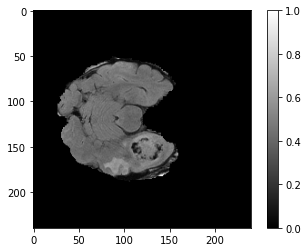

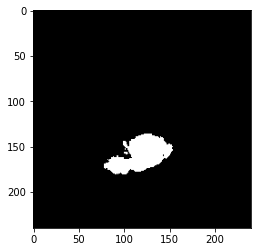

In [175]:
plt.imshow(x_train[5, :, :, 0], cmap=plt.cm.gray)
plt.colorbar()
plt.figure()
plt.imshow(y_train[5, :, :, 0], cmap=plt.cm.gray)

In [7]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(100, 240, 240, 4) (100, 240, 240, 1)
(20, 240, 240, 4) (20, 240, 240, 1)


In [ ]:
# take out if not working
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True
)
labelgen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True
)


datagen.fit(x_train) # ytrain
labelgen.fit(y_train)


If you would like to calculate mean IoU, make sure to switch over to Binary Cross Entropy, 1 class for num_classes, and sigmoid activation in final Dense layer for logits.

For PSNR, SparseCategorical Cross Entropy seems to work better, with softmax activation in final dense layer and 2 classes for num_classes.

For some reason, BinaryCrossEntropy seems to give large validation losses initially, so all plots are made with SparseCategorical to better show decrease in loss.

In [187]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
 # try to add regularization
def create_unet(input_shape, num_classes):
    input_layer = Input(input_shape)
    x = input_layer
    x = BatchNormalization()(x)
    # down path
    start_filters = 16
    skip_layers = []
    for i in range(4):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        skip_layers.append(x)
        if i == 3:
            x = Dropout(0.5)(x)  # take out if not working
        x = MaxPool2D()(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # up path
    for i in range(4):
        x = UpSampling2D()(x)
        x = tf.concat([skip_layers[-(i+1)], x], axis=-1)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
    output = Conv2D(num_classes, 1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output) #use 1 class, sigmoid dense, and binarycrossentropy
    return model

model = create_unet([240, 240, 4], 1)

In [177]:
model.summary()

Model: "functional_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 240, 240, 4) 0                                            
__________________________________________________________________________________________________
batch_normalization_340 (BatchN (None, 240, 240, 4)  16          input_36[0][0]                   
__________________________________________________________________________________________________
conv2d_646 (Conv2D)             (None, 240, 240, 16) 592         batch_normalization_340[0][0]    
__________________________________________________________________________________________________
conv2d_647 (Conv2D)             (None, 240, 240, 16) 2320        conv2d_646[0][0]                 
______________________________________________________________________________________

In [180]:
# extra metrics
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred[:, :, :, 1][..., tf.newaxis], 1)  # this is not an important metric for segmentation, but will be left here in case it is beneficial for user to analyze

def psnr(y_true, y_pred):
    # return y_pred.shape
    y_onechannel = y_pred[:, :, :, 0][..., tf.newaxis]
    return tf.image.psnr(y_true, y_onechannel, 1)


In [188]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 3e-2), loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', psnr, tf.keras.metrics.MeanIoU(num_classes=2)])  # metrics=[tf.keras.metrics.MeanIoU(num_classes=2)] [tf.keras.metrics.RootMeanSquaredError()]
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.0001)  # this is new, take out if bad
history = model.fit(x_train, y_train, batch_size=8, epochs=25, callbacks=[reduce_lr], validation_data=(x_test, y_test)) # use validation only for validation, evaluate on test that is different


# history = model.fit(datagen.flow(x_train, y_train, batch_size=8),
#           epochs=30, callbacks=[reduce_lr], validation_data=validation_datagen.flow(x_test, y_test, batch_size=4))

Epoch 1/25
13/13 [==============================] - 1s 98ms/step - loss: 0.4639 - accuracy: 0.8321 - psnr: 9.2660 - mean_io_u_17: 0.4926 - val_loss: 2421469.7500 - val_accuracy: 0.0304 - val_psnr: 0.1344 - val_mean_io_u_17: 0.0154
Epoch 2/25
13/13 [==============================] - 1s 56ms/step - loss: 0.1030 - accuracy: 0.9852 - psnr: 19.8210 - mean_io_u_17: 0.4926 - val_loss: 41552.8828 - val_accuracy: 0.0462 - val_psnr: 0.2059 - val_mean_io_u_17: 0.0236
Epoch 3/25
13/13 [==============================] - 1s 57ms/step - loss: 0.0547 - accuracy: 0.9852 - psnr: 23.4797 - mean_io_u_17: 0.4926 - val_loss: 9076.1816 - val_accuracy: 0.0184 - val_psnr: 0.0809 - val_mean_io_u_17: 0.0092
Epoch 4/25
13/13 [==============================] - 1s 57ms/step - loss: 0.0451 - accuracy: 0.9865 - psnr: 23.7409 - mean_io_u_17: 0.4926 - val_loss: 700.0576 - val_accuracy: 0.0182 - val_psnr: 0.0804 - val_mean_io_u_17: 0.0092
Epoch 5/25
13/13 [==============================] - 1s 58ms/step - loss: 0.0402 - 

dict_keys(['loss', 'accuracy', 'psnr', 'val_loss', 'val_accuracy', 'val_psnr', 'lr'])


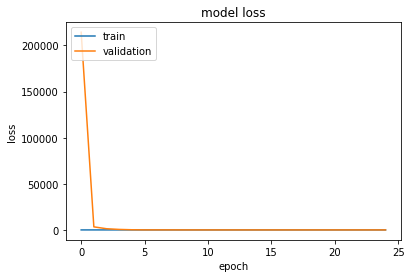

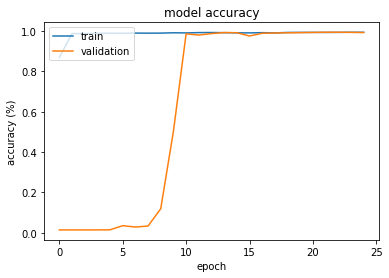

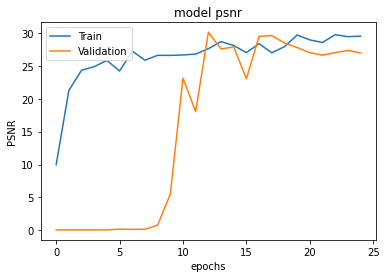

In [182]:
print(history.history.keys())
def plotting_parameters():
  # "Loss"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss']) #history.history['rmse', 'meaniou'] potentially
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy (%)')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.figure()
  plt.plot(history.history['psnr'])
  plt.plot(history.history['val_psnr'])
  plt.title('model psnr')
  plt.ylabel('PSNR')
  plt.xlabel('epochs')
  plt.legend(['Train', 'Validation'], loc='upper left')
  # plt.figure()
  # plt.plot(history.history['mean_io_u'])
  # plt.title('model mean IoU')
  # plt.ylabel('IoU')
  # plt.xlabel('epochs')
  
  
  

plotting_parameters()

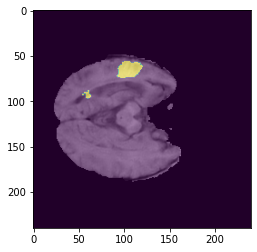

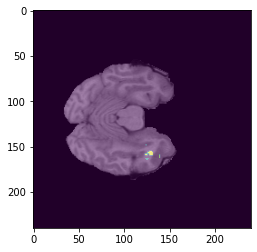

In [183]:
br = 4
plt.imshow(x_test[br, :, :, 1], cmap=plt.cm.gray)

plt.imshow(y_test[br, :, :, 0], alpha = .5)
plt.figure()
plt.imshow(x_train[br +3, :, :, 1], cmap=plt.cm.gray)

plt.imshow(y_train[br+3, :, :, 0], alpha = .5)

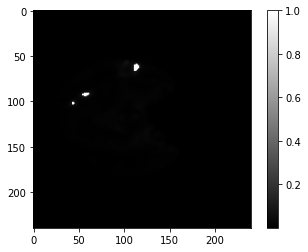

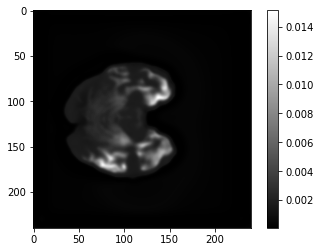

In [190]:
good_pred = model.predict(x_test[br:br+1])[0]
# good_pred[good_pred> .1] = 1
plt.imshow(good_pred[:, :, 0], cmap=plt.cm.gray)
plt.colorbar()
train_pred = model.predict(x_train[7:8])[0]
# train_pred[train_pred> .1] = 1
plt.figure()
plt.imshow(train_pred[:, :, 0], cmap=plt.cm.gray) #output colorbar to see if there is any significant difference
plt.colorbar()

In [46]:
loss = model.evaluate(x_test, y_test, batch_size=4)

5/5 [==============================] - 0s 13ms/step - loss: 0.0472 - accuracy: 0.9858 - psnr: 25.4728


## Physical Layer

This is the first iteration of the physical layer, where logits can vary to be anything. This is not physically realizable in MR, since you can't weight frequencies like that. This is merely here to show an iterative step in the development of the physical layer, that will effectively choose k-space columns to subsample.

You can mess around with learning rate: here it is .03 because there is a large amount of BatchNorms, which permit this. If training is going poorly, perhaps take out some BatchNorms and decrease lr, or decrease LR on Plateau


In [203]:
import tensorflow_probability as tfp
class Physical(tf.keras.layers.Layer):
    def __init__(self, features_in, features_out):
        super(Physical, self).__init__()
        # self.kernel = tf.tile(tf.Variable(initial_value=tf.random.uniform([1, features_in, 1], maxval=1), trainable=True),
        #                       [features_out, 1, 1])
        self.kernel = tf.Variable(initial_value=tf.ones((1, features_in, 1)))
        self.features_out = features_out

    def call(self, inputs):
        fourier = tf.signal.fftshift(tf.signal.fft2d(tf.cast(inputs, dtype=tf.complex64)))
        sampled_kspace = tf.math.multiply(tf.tile(tf.cast(self.kernel, dtype=tf.complex64), [self.features_out, 1, 1]), fourier)
        inv_fourier = tf.signal.ifft2d(tf.signal.ifftshift(sampled_kspace))
        image = tf.square(tf.abs(inv_fourier))
        return image


In [206]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
# subsample_kernel = tf.Variable(initial_value=tf.random.uniform([240, 240, 1], maxval=1), trainable=True)
# subsample_kernel = tf.tile(tf.Variable(initial_value=tf.random.uniform([1, 240, 1], maxval=1), trainable=True), [240, 1, 1])

def create_unet(input_shape, num_classes):
    input_layer = Input(input_shape)
    x = input_layer

    # subsample_kernel = tf.tile(tf.Variable(initial_value=tf.random.uniform([1, 240, 1], maxval=1), trainable=True), [240, 1, 1])
    # subsample_kernel = tf.Variable(initial_value=tf.ones([240, 240, 1], dtype=tf.complex64), trainable=True)
    # subsample_kernel = subsample_kernel[tf.newaxis, ...]

    # fourier = tf.signal.fftshift(tf.signal.fft2d(tf.cast(x, dtype=tf.complex64))) #make sure they look as expected
    # sampled_kspace = tf.math.multiply(tf.cast(subsample_kernel, dtype=tf.complex64), fourier)
    # full_image = tf.signal.ifft2d(tf.signal.ifftshift(sampled_kspace))
    # image = tf.square(tf.abs(full_image)) #have values changed after implementation?

    x = Physical(240, 240)(x) # do relaxed bernoulli after this and before cnn

    x = BatchNormalization()(x)
    # down path
    start_filters = 16
    skip_layers = []
    for i in range(4):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        skip_layers.append(x)
        if i == 3:
            x = Dropout(0.5)(x)  # take out if not working
        x = MaxPool2D()(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # up path
    for i in range(4):
        x = UpSampling2D()(x)
        x = tf.concat([skip_layers[-(i+1)], x], axis=-1) #maybe mult by scale
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x) #try leaky relu so gradients dont die
        x = BatchNormalization()(x)
    output = Conv2D(num_classes, 1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

model = create_unet([240, 240, 4], 1)

In [201]:
model.summary()

Model: "functional_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 240, 240, 4) 0                                            
__________________________________________________________________________________________________
physical_27 (Physical)          (None, 240, 240, 4)  240         input_41[0][0]                   
__________________________________________________________________________________________________
batch_normalization_380 (BatchN (None, 240, 240, 4)  16          physical_27[0][0]                
__________________________________________________________________________________________________
conv2d_722 (Conv2D)             (None, 240, 240, 16) 592         batch_normalization_380[0][0]    
______________________________________________________________________________________

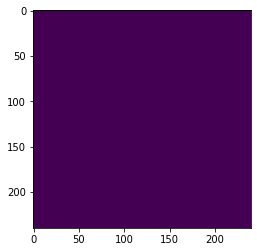

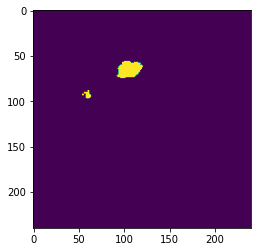

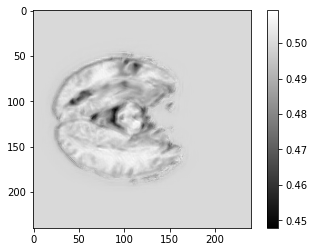

In [74]:
filter = model.layers[1].get_weights()
plt.imshow(tf.tile(filter[0], [240, 1, 1])[:, :, 0].numpy())

plt.figure()
plt.imshow(y_test[br][:, :, 0])

plt.figure()
bad_pred = model.predict(x_test[br:br+1])[0]
# good_pred[good_pred> .1] = 1
plt.imshow(bad_pred[:, :, 1], cmap=plt.cm.gray)
plt.colorbar()

In [207]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 3e-2), loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', psnr, tf.keras.metrics.MeanIoU(num_classes=2)])  # originally 3e-3
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.0001)  # this is new, take out if bad
# print_weights = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: plt.imshow(tf.abs(subsample_kernel[:,:,0])))

history = model.fit(x_train, y_train, batch_size=8, epochs=20, callbacks=[reduce_lr], validation_data=(x_test, y_test))


# history = model.fit(datagen.flow(x_train, y_train, batch_size=8),
#           epochs=15, callbacks=[reduce_lr], validation_data=validation_datagen.flow(x_test, y_test, batch_size=4))

Epoch 1/20
13/13 [==============================] - 1s 103ms/step - loss: 0.4711 - accuracy: 0.8744 - psnr: 9.0123 - mean_io_u_22: 0.4926 - val_loss: 42091.0078 - val_accuracy: 0.0138 - val_psnr: 0.0608 - val_mean_io_u_22: 0.0069
Epoch 2/20
13/13 [==============================] - 1s 61ms/step - loss: 0.0917 - accuracy: 0.9881 - psnr: 19.9516 - mean_io_u_22: 0.4926 - val_loss: 966.5602 - val_accuracy: 0.0138 - val_psnr: 0.0609 - val_mean_io_u_22: 0.0070
Epoch 3/20
13/13 [==============================] - 1s 61ms/step - loss: 0.0380 - accuracy: 0.9891 - psnr: 26.1396 - mean_io_u_22: 0.4926 - val_loss: 117.2626 - val_accuracy: 0.0307 - val_psnr: 0.1509 - val_mean_io_u_22: 0.0735
Epoch 4/20
13/13 [==============================] - 1s 60ms/step - loss: 0.0350 - accuracy: 0.9879 - psnr: 25.9355 - mean_io_u_22: 0.4926 - val_loss: 108.1052 - val_accuracy: 0.0198 - val_psnr: 0.0964 - val_mean_io_u_22: 0.0451
Epoch 5/20
13/13 [==============================] - 1s 60ms/step - loss: 0.0331 - accu

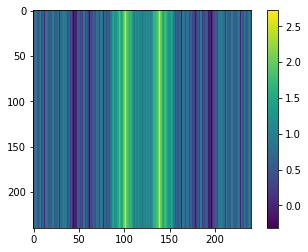

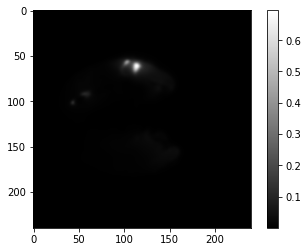

In [208]:
filter = model.layers[1].get_weights()
plt.imshow(tf.tile(filter[0], [240, 1, 1])[:, :, 0].numpy())
plt.colorbar()

plt.figure()
good_pred = model.predict(x_test[br:br+1])[0]
# good_pred[good_pred> .08] = 1
plt.imshow(good_pred[:, :, 0], cmap=plt.cm.gray)  # if using binary cross entropy, final dimaension should be 0, if using Sparse, final dimension should be 1
plt.colorbar()


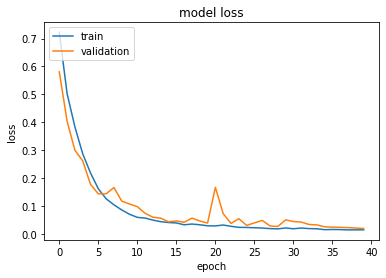

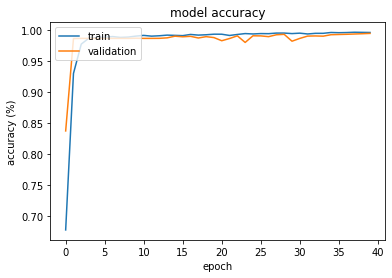

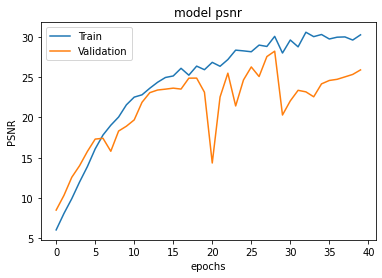

In [93]:
plotting_parameters()

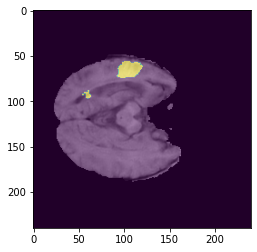

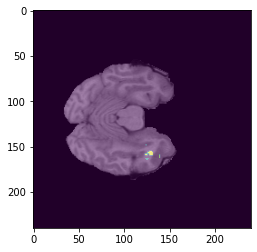

In [125]:
br = 4
plt.imshow(x_test[br, :, :, 1], cmap=plt.cm.gray)

plt.imshow(y_test[br, :, :, 0], alpha = .5)
plt.figure()
plt.imshow(x_train[br +3, :, :, 1], cmap=plt.cm.gray)

plt.imshow(y_train[br+3, :, :, 0], alpha = .5)

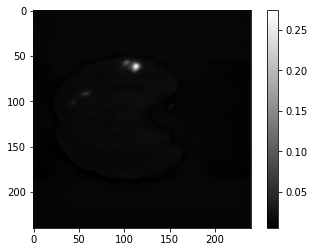

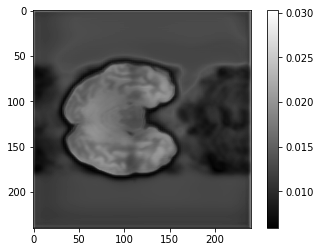

In [126]:
good_pred = model.predict(x_test[br:br+1])[0]
# good_pred[good_pred> .1] = 1
plt.imshow(good_pred[:, :, 1], cmap=plt.cm.gray)
plt.colorbar()
train_pred = model.predict(x_train[7:8])[0]
# train_pred[train_pred> .1] = 1

plt.figure()
plt.imshow(train_pred[:, :, 1], cmap=plt.cm.gray)
plt.colorbar()

## Relaxed One-Hot Categorical Distribution

This is the same thing as the previous physical layer, except now, values are pushed to be either 1 or 0, instead of varying, since only 1 or 0 are possible in real life.

Steps for this layer:

1. Create initial optimizable tensor with size (num_samples, image_size)
2. Set temp to around .4 and create sample distribution based on relaxed one-hot categorical distribution
3. Reduce sum across first axis, then tile to  be image size
4. Multiply by image frequency data

When calling in model, you can vary number of samples, the first argument of the custom layer. This will give off different masks and kernels. Note that number of trainable parameters will change when varying samples. No plots are outputted, though you are welcome to run the call to the plotting function at the bottom. This is done because it is not as useful to look at individual data, and instead it is useful to look at comparison of sampling sizes.

In [161]:
import tensorflow_probability as tfp
class Physical(tf.keras.layers.Layer):
    def __init__(self, samples_num, features_in, features_out):
        super(Physical, self).__init__()

        logits = tf.ones((1, samples_num, features_in, 1))
        dist = tfp.distributions.RelaxedOneHotCategorical(temperature=0.4, logits=logits)
        self.sample = tf.Variable(dist.sample())
        self.features_out = features_out

    def call(self, inputs):

        fourier = tf.signal.fftshift(tf.signal.fft2d(tf.cast(inputs, dtype=tf.complex64)))
        sampled_kspace = tf.math.multiply(tf.tile(tf.cast(tf.reduce_sum(self.sample, axis=1), dtype=tf.complex64), [self.features_out, 1, 1]), fourier)
        inv_fourier = tf.signal.ifft2d(tf.signal.ifftshift(sampled_kspace))
        image = tf.square(tf.abs(inv_fourier))
        return image


In [162]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
# subsample_kernel = tf.Variable(initial_value=tf.random.uniform([240, 240, 1], maxval=1), trainable=True)
# subsample_kernel = tf.tile(tf.Variable(initial_value=tf.random.uniform([1, 240, 1], maxval=1), trainable=True), [240, 1, 1])[tf.newaxis, ...]

def create_unet(input_shape, num_classes, temp=1):

    input_layer = Input(input_shape)
    x = input_layer

    x = Physical(15, 240, 240)(x) # do relaxed bernoulli after this and before cnn

    x = BatchNormalization()(x)
    # down path
    start_filters = 16
    skip_layers = []
    for i in range(4):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        skip_layers.append(x)
        if i == 3:
            x = Dropout(0.5)(x)  # take out if not working
        x = MaxPool2D()(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # up path
    for i in range(4):
        x = UpSampling2D()(x)
        x = tf.concat([skip_layers[-(i+1)], x], axis=-1) #maybe mult by scale
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x) #try leaky relu so gradients dont die
        x = BatchNormalization()(x)
    output = Conv2D(num_classes, 1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

model = create_unet([240, 240, 4], 1)

In [163]:
model.summary()

Model: "functional_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 240, 240, 4) 0                                            
__________________________________________________________________________________________________
physical_24 (Physical)          (None, 240, 240, 4)  3600        input_35[0][0]                   
__________________________________________________________________________________________________
batch_normalization_330 (BatchN (None, 240, 240, 4)  16          physical_24[0][0]                
__________________________________________________________________________________________________
conv2d_627 (Conv2D)             (None, 240, 240, 16) 592         batch_normalization_330[0][0]    
______________________________________________________________________________________

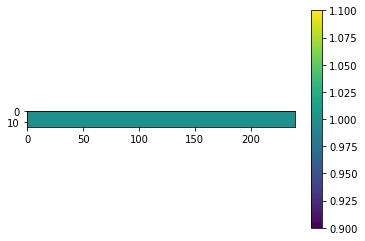

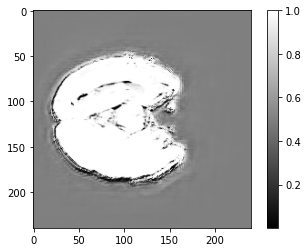

In [164]:
filter = model.layers[1].get_weights()
plt.imshow(filter[0][0, :, :, 0])
plt.colorbar()

plt.figure()
bad_pred = model.predict(x_test[br:br+1])[0]
# bad_pred[bad_pred> .08] = 1
plt.imshow(bad_pred[:, :, 0], cmap=plt.cm.gray)
plt.colorbar()


In [165]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 3e-2), loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])  # originally 3e-3
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.0001)  # this is new, take out if bad
# print_weights = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: plt.imshow(subsample_kernel[0,:,:,0]))

history = model.fit(x_train, y_train, batch_size=8, epochs=40, callbacks=[reduce_lr], validation_data=(x_test, y_test))


# history = model.fit(datagen.flow(x_train, y_train, batch_size=8),
#           epochs=15, callbacks=[reduce_lr], validation_data=validation_datagen.flow(x_test, y_test, batch_size=4))

Epoch 1/40
13/13 [==============================] - 1s 98ms/step - loss: 0.4645 - accuracy: 0.8516 - mean_io_u_16: 0.4926 - val_loss: 1532701.7500 - val_accuracy: 0.0138 - val_mean_io_u_16: 0.0069
Epoch 2/40
13/13 [==============================] - 1s 60ms/step - loss: 0.0991 - accuracy: 0.9883 - mean_io_u_16: 0.4926 - val_loss: 65030.4375 - val_accuracy: 0.0138 - val_mean_io_u_16: 0.0069
Epoch 3/40
13/13 [==============================] - 1s 59ms/step - loss: 0.0427 - accuracy: 0.9878 - mean_io_u_16: 0.4926 - val_loss: 2282.3530 - val_accuracy: 0.0138 - val_mean_io_u_16: 0.0069
Epoch 4/40
13/13 [==============================] - 1s 59ms/step - loss: 0.0336 - accuracy: 0.9899 - mean_io_u_16: 0.4926 - val_loss: 486.4819 - val_accuracy: 0.0138 - val_mean_io_u_16: 0.0069
Epoch 5/40
13/13 [==============================] - 1s 60ms/step - loss: 0.0309 - accuracy: 0.9904 - mean_io_u_16: 0.4926 - val_loss: 282.3157 - val_accuracy: 0.0138 - val_mean_io_u_16: 0.0074
Epoch 6/40
13/13 [==========

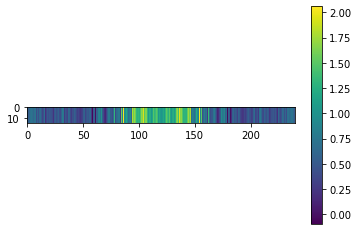

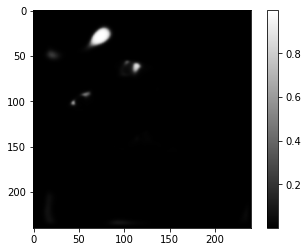

In [166]:
filter = model.layers[1].get_weights()
plt.imshow(filter[0][0, :, :, 0])
plt.colorbar()

plt.figure()
good_pred = model.predict(x_test[br:br+1])[0]
# good_pred[good_pred> .08] = 1
plt.imshow(good_pred[:, :, 0], cmap=plt.cm.gray)
plt.colorbar()


The values here are manually typed in after training finished. There is a more robust method for doing this, but due to time constraints, each sampling size was just run through the model and manually typed in here.

It is interesting that segmentations seem to get worse with less samples, yet MeanIoU improves. This could be purely due to chance or just unimportant with how low the values are to begin with, and how little they truly vary from each other

Text(0.5, 1.0, 'Mean IoU vs. Number of k-space Samples Taken')

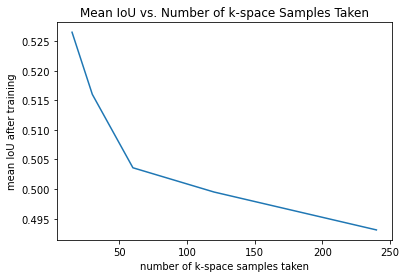

In [168]:
num_samples = np.array([240, 120, 60, 30, 15])
mean_IoU = np.array([.4931, .4995, .5036, .5160, .5265])
plt.plot(num_samples, mean_IoU)
plt.xlabel('number of k-space samples taken')
plt.ylabel('mean IoU after training')
plt.title('Mean IoU vs. Number of k-space Samples Taken')

In [ ]:
plotting_parameters()

## Scratch Work

In [ ]:
# create a 1x240 tensor of weights, and create columns by expanding downward to 240, 240, multiply by temperature parameter (either softmax or |w/wmax|) and update per epoch
# relaxed categorical distributions, relaxed bernoulli (dist that is 0 or 1), instead of optimizing weights optimize likelihood (initialize at val and what is prob that i turn k space sample on or off)
# allow you to turn on temp, or how close to a discrete dist it is, set temperature to .1, set of probablities to get actual values like in lab
# how close are values are vals to being 0 or 1, sampe dist to get k space weights, optimize probablities on or off. you don't have to use annelaing in this case get values of 0 or 1
# use logits bc unrestricted, vector will be optimized and input to distribution  sample k sapce vector and sample will have values of 0 or 1, use for physical modulation
# step thru creating set of logits, an pass in and look for values matching what i want, what logits go with what values.
import tensorflow as tf

# subsample_kernel = tf.tile(tf.Variable(initial_value=tf.random.uniform([1, 240, 1], maxval=1), trainable=True), [240, 1, 1])[tf.newaxis, ...]
subsample_kernel =tf.Variable(initial_value=tf.ones([240, 240, 1]))
# subsample_kernel = tf.expand_dims(subsample_kernel, 0)
# def physical_layer(batch):
#   fourier = tf.signal.fftshift(tf.signal.fft2d(tf.cast(batch, dtype=tf.complex64))) # make sure look as expected
#   sampled_kspace = tf.math.multiply(subsample_kernel, fourier) #make sure dc where it should be, ffts of fft, of ifft
#   full_image = tf.signal.ifft2d(tf.signal.ifftshift(sampled_kspace))
#   image = tf.square(tf.abs(full_image)) #have values changed
#   return image
print(subsample_kernel)
def physical_layer(batch):
    image = tf.math.multiply(batch, subsample_kernel)
    print(subsample_kernel)
    return image